### Домашнее задание к лекции 2

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибки моделей из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

РЕШЕНИЕ:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

Time  PJME_MW  year  month  dayofmonth  quarter  dayofyear  \
Date                                                                         
2002-01-01  01:00:00  30393.0  2002      1           1        1          1   
2002-01-01  02:00:00  29265.0  2002      1           1        1          1   
2002-01-01  03:00:00  28357.0  2002      1           1        1          1   
2002-01-01  04:00:00  27899.0  2002      1           1        1          1   
2002-01-01  05:00:00  28057.0  2002      1           1        1          1   

            weekofyear  dayofweek  hour  is_holiday  is_prev_holiday  \
Date                                                                   
2002-01-01           1          1     1           1                0   
2002-01-01           1          1     2           1                0   
2002-01-01           1          1     3           1                0   
2002-01-01           1          1     4           1                0   
2002-01-01           1          1     5           1                0   

            is_next_holiday  
Date                         
2002-01-01                0  
2002-01-01                0  
2002-01-01                0  
2002-01-01                0  
2002-01-01                0

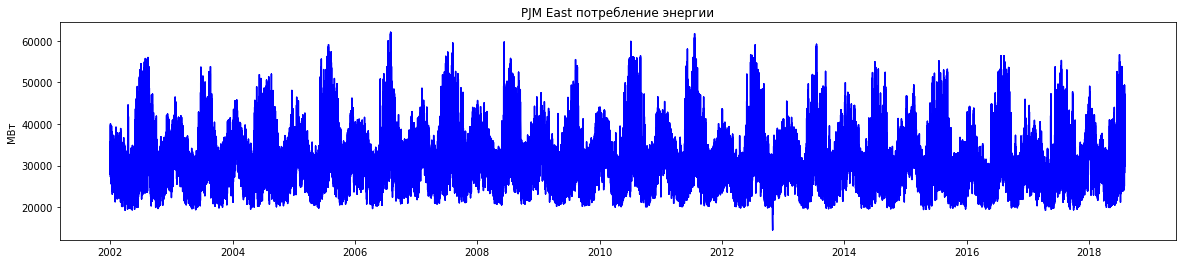

In [3]:

plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [4]:
scl =StandardScaler()
scly =StandardScaler()

def split_data_b( data, split_date ):
    '''функция для разделения на трейн и тест'''
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    '''функуция для оценки MAE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exponential_smoothing(series, alpha):
    '''функуци] для експоненциального сглаживания'''
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [5]:
def predict_whis_lag(df, lag, N2, split_data, coll_value, ylabel, xlabel, resample = 'D' ):
    '''функция для настройки модели, выделения остатков, сезонности, предсказания и оценки точности предсказания'''
    h=lag
    
    d_data=df.resample(resample).mean()
    b_s = pd.DataFrame(data = d_data[[coll_value]])
    b_ar_exp_1 = exponential_smoothing(d_data[coll_value], 0.1)

    plt.figure(figsize=(20, 9))
    plt.plot(b_s.index, b_s[coll_value], label='исходный ряд')
    plt.plot(b_s[coll_value].rolling(window=N2).mean(), label="скользящие средние");
    plt.plot(b_s.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
    mw_trend_free = b_s[coll_value] - b_ar_exp_1
    plt.plot(b_s.index, mw_trend_free, color = 'green', label="без тренда по экспоненциальному сглаживанию");
    plt.xlabel('time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(coll_value)
    
    st_dt = sm.tsa.stattools.adfuller(mw_trend_free , regression = 'ctt')
    if st_dt[1] < 10**(-3):
        print(f'p_value = {st_dt[1]}, отстаточный ряд стационарный')
    else:
        print(f'p_value = {st_dt[1]}, отстаточный ряд нестационарный')
        
    b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = b_s.index)
    df_prepared= pd.DataFrame(b_ar_exp_1)
    
    train_b, test_b = split_data_b( df_prepared, split_data)
    
    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df_prepared.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df_prepared.columns[0]].values[h:]
    
    
    plt.figure( figsize=( 15, 7 ))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(train_b.index,train_b[df_prepared.columns[0]], label='train data' )
    plt.plot(test_b.index,test_b[df_prepared.columns[0]], label='test data')
    plt.title( 'Тестовые и тренировочные данные' )
    plt.legend()
    plt.show()

    model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100) 
    model_gb.fit( X_train_b, y_train_b ) 
    X_test_pred_gb = model_gb.predict(X_test_b)

    plt.figure( figsize=( 20, 4 ))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
    plt.plot(test_b.index[h:],y_test_b, label='test data')
    plt.plot(b_s.loc[split_data:].index, b_s.loc[split_data:][coll_value], label='исходный ряд')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

    print('ошибка градиентного бустинга :  ', er_g, '%')

p_value = 1.7584171314313822e-13, отстаточный ряд стационарный


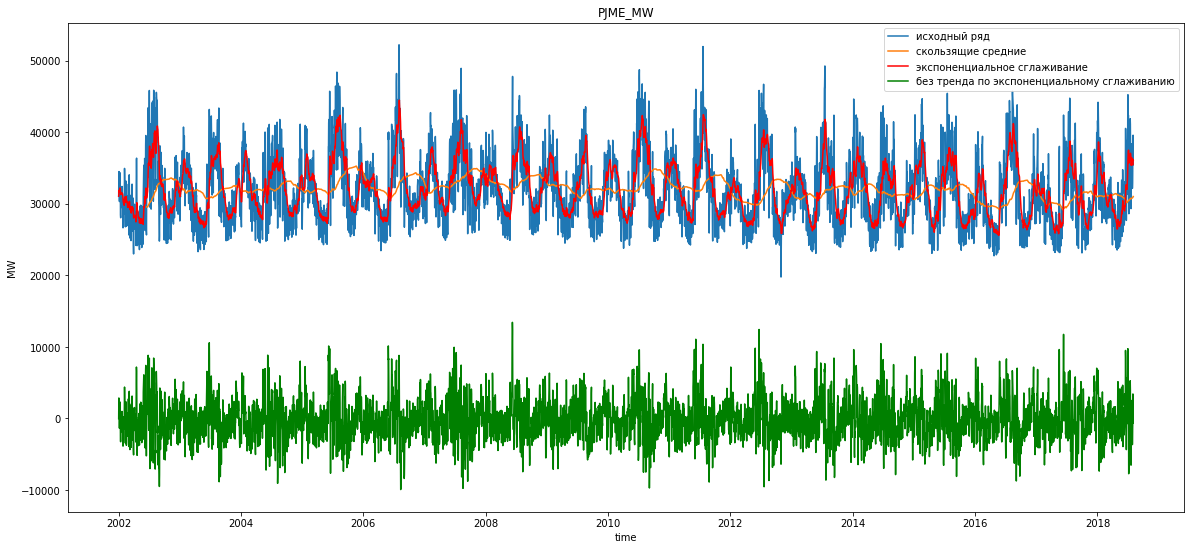

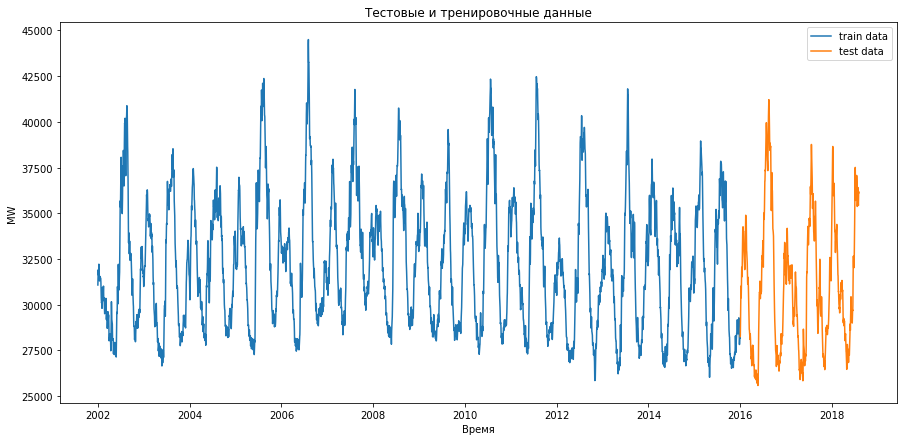

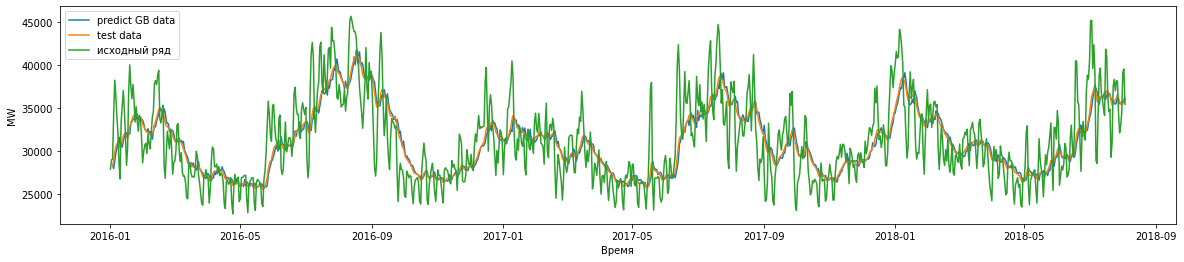

ошибка градиентного бустинга :   1.081107896727105 %


In [10]:
# посмотрим на качество моделим с глубиной лага 1
predict_whis_lag(df = data, lag = 1, N2 = 24*7, split_data = '2016-01-01', \
                 coll_value ='PJME_MW', ylabel = 'MW' , xlabel = 'Время', resample = 'D' )

p_value = 1.7584171314313822e-13, отстаточный ряд стационарный


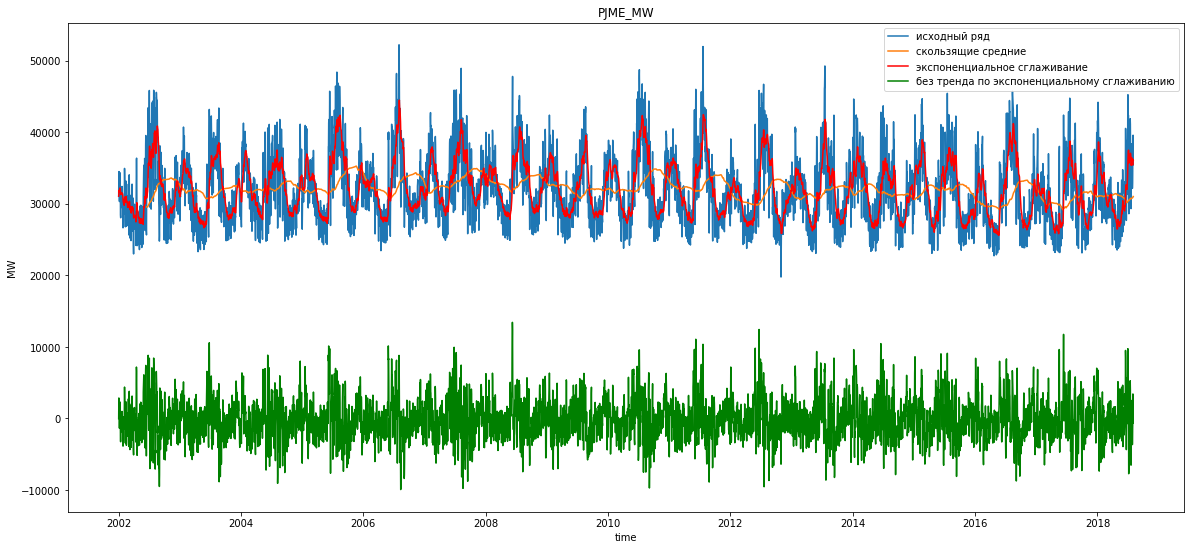

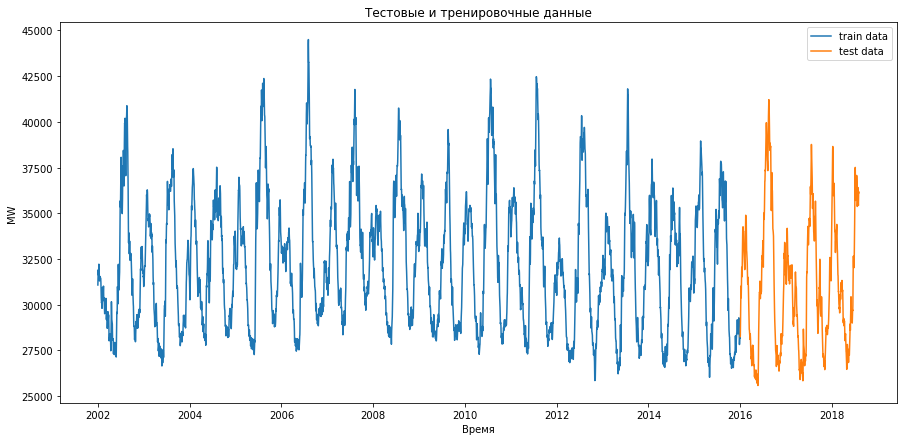

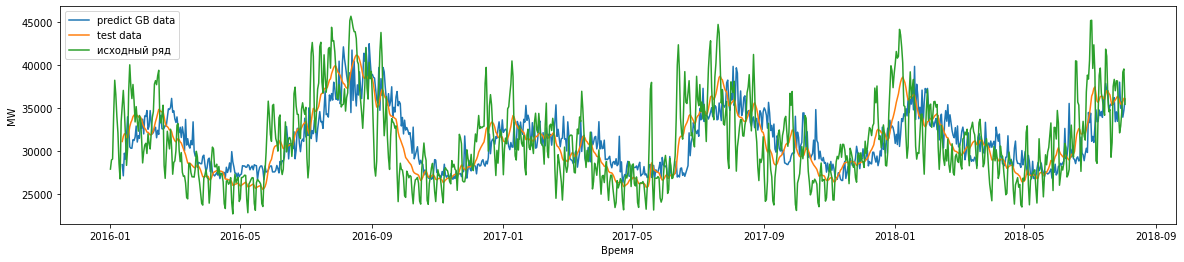

ошибка градиентного бустинга :   5.347974061515608 %


In [12]:
# посмотрим на качество моделим с глубиной лага 10
predict_whis_lag(df = data, lag = 10, N2 = 24*7, split_data = '2016-01-01', \
                 coll_value ='PJME_MW', ylabel = 'MW' , xlabel = 'Время', resample = 'D' )

Вывод: чем больше лаг тем меньше точность

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :). - **c сезонном, возможно будет тренд на больших периодах порядка десятилений**
    
    б) Количество денег, которые тратят покупатели в интернет магазине. - **c сезонным трендом, тренд будет так как все больше покупателей становится со временем**
    
    в) Вес растущего котенка. - **c трендом и цикличностью, так как рост организмов непостоянен во времени**
    
    г) Прирост объема деревьев в лесу от времени - **c мультипликативным трендом и циклами**

*В качестве эксперимента выделим тренд и сезоны с Prophet для PJME_MW

In [13]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()

In [18]:
data['Date'] = data.index
df = data[['Date','PJME_MW']].dropna().drop_duplicates()
df.columns = ['ds', 'y']
df

ds        y
Date                          
2002-01-01 2002-01-01  30393.0
2002-01-01 2002-01-01  29265.0
2002-01-01 2002-01-01  28357.0
2002-01-01 2002-01-01  27899.0
2002-01-01 2002-01-01  28057.0
...               ...      ...
2018-08-02 2018-08-02  44057.0
2018-08-02 2018-08-02  43256.0
2018-08-02 2018-08-02  41552.0
2018-08-02 2018-08-02  38500.0
2018-08-03 2018-08-03  35486.0

[145216 rows x 2 columns]

In [19]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
145576 2019-07-30
145577 2019-07-31
145578 2019-08-01
145579 2019-08-02
145580 2019-08-03

In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
145576 2019-07-30  38002.030785  31118.735549  45109.811544
145577 2019-07-31  37892.886788  31082.479602  45476.274399
145578 2019-08-01  37616.521906  30685.717782  44720.367545
145579 2019-08-02  37121.459163  29787.313663  44091.004920
145580 2019-08-03  34493.957471  27030.663773  41537.592440

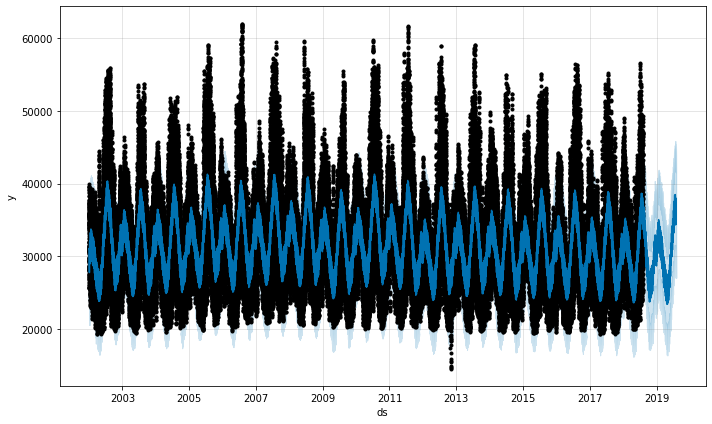

In [22]:
fig1 = m.plot(forecast)

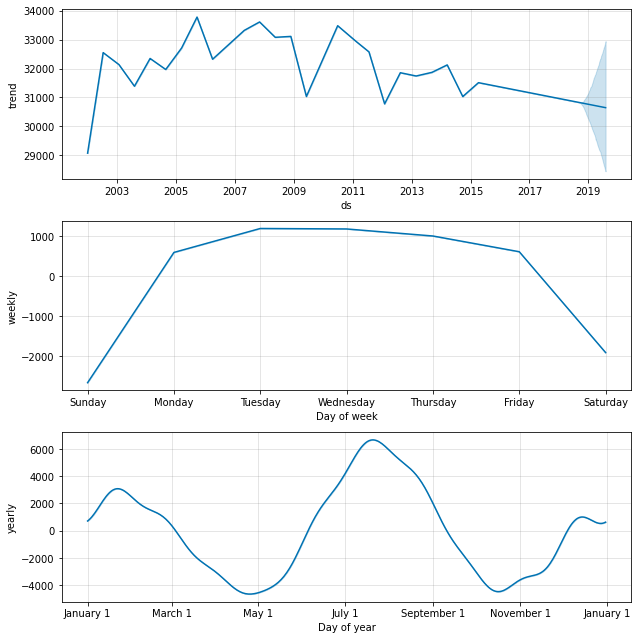

In [23]:
fig2 = m.plot_components(forecast)